---
title: "Cortex Forecast Example"
date: "08/20/2024"
format:
    html:
        code-fold: False
        output: False
---

# Overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| hide
from nbdev.showdoc import *

# Example Useage

In [3]:
#| skip
from cortex_forecast.forecast import SnowflakeMLForecast
from snowflake.snowpark.version import VERSION
import os

In [4]:
#| skip
forecast_model = SnowflakeMLForecast(
    config_file='./cortex_forecast/files/yaml/taxi_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    }
)

snowflake_environment = forecast_model.session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(forecast_model.session.get_current_role()))
print('Database                    : {}'.format(forecast_model.session.get_current_database()))
print('Schema                      : {}'.format(forecast_model.session.get_current_schema()))
print('Warehouse                   : {}'.format(forecast_model.session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0], snowpark_version[1], snowpark_version[2]))


Connection Established with the following parameters:
User                        : JD_SERVICE_ACCOUNT_ADMIN
Role                        : "CORTEX_USER_ROLE"
Database                    : "CORTEX"
Schema                      : "DEV"
Warehouse                   : "CORTEX_WH"
Snowflake version           : 8.33.0
Snowpark for Python version : 1.19.0


# Make Data Sets

> TODO: Come in and create the data assets, but for now we are skipping directly to a training table and a inference table. 

Create these tables by following along the [snowflake QuickStart](https://quickstarts.snowflake.com/guide/geo-for-machine-learning/index.html#2)

In [5]:
# Making Smaller Data Set Training
forecast_model.run_command("""
CREATE OR REPLACE TABLE cortex.dev.ny_taxi_rides_h3_train as
SELECT *
   FROM ny_taxi_rides_h3_train
WHERE TO_TIMESTAMP_NTZ(pickup_time) BETWEEN 
DATEADD(day, -60, (SELECT MAX(pickup_time) FROM NY_TAXI_RIDES_H3_TRAIN)) 
AND (SELECT MAX(pickup_time) FROM NY_TAXI_RIDES_H3_TRAIN)
AND H3 in ('882a100d6bfffff', '882a100899fffff', '882a100d29fffff', '882a107259fffff');
""")


[Row(status='Table NY_TAXI_RIDES_H3_TRAIN successfully created.')]

In [6]:
# Making Smaller Data Sets Inference Table 
forecast_model.run_command("""
CREATE OR REPLACE TABLE cortex.dev.ny_taxi_rides_h3_predict as
SELECT *
   FROM ny_taxi_rides_h3_predict
WHERE TO_TIMESTAMP_NTZ(pickup_time) BETWEEN 
DATEADD(day, -60, (SELECT MAX(pickup_time) FROM ny_taxi_rides_h3_predict)) 
AND (SELECT MAX(pickup_time) FROM ny_taxi_rides_h3_predict)
AND H3 in ('882a100d6bfffff', '882a100899fffff', '882a100d29fffff', '882a107259fffff');
""")

[Row(status='Table NY_TAXI_RIDES_H3_PREDICT successfully created.')]

## Preview Training Table

In [7]:
forecast_model.session.sql(f"""
    SELECT * FROM {forecast_model.config['input_data']['table']} LIMIT 10
""").to_pandas()

,PICKUP_TIME,H3,PICKUPS,SCHOOL_HOLIDAY,PUBLIC_HOLIDAY,SPORT_EVENT
0,2015-04-23 16:00:00,882a100d29fffff,1196,None,None,None
1,2015-04-18 12:00:00,882a100d6bfffff,430,None,None,None
2,2015-04-13 13:00:00,882a100d29fffff,715,None,None,None
3,2015-04-08 05:00:00,882a100d6bfffff,570,None,None,None
4,2015-04-07 07:00:00,882a100d29fffff,734,None,None,None
5,2015-04-28 09:00:00,882a100d6bfffff,369,None,None,None
6,2015-04-11 09:00:00,882a100899fffff,325,None,None,None
7,2015-05-05 18:00:00,882a100d29fffff,1094,None,None,None
8,2015-04-14 20:00:00,882a107259fffff,96,None,None,None
9,2015-04-30 01:00:00,882a100899fffff,94,None,None,None


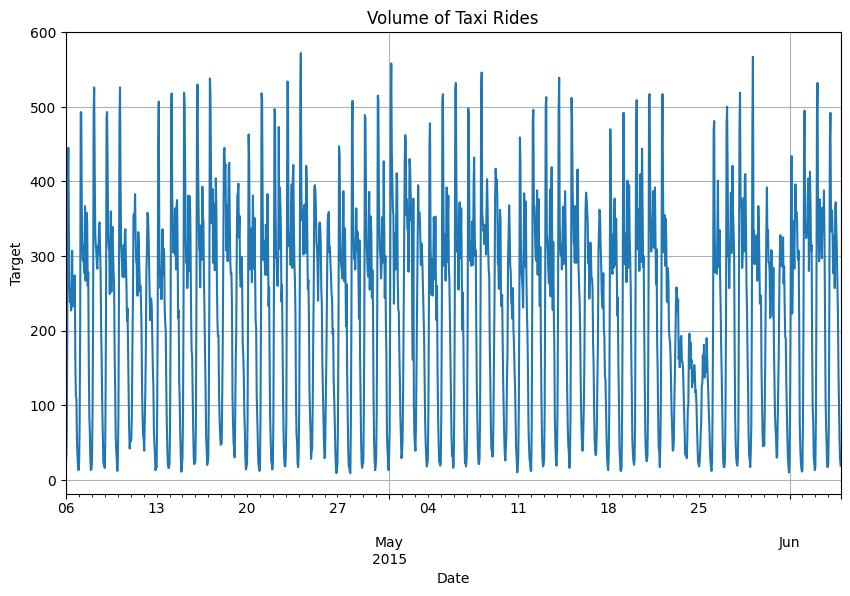

In [8]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = forecast_model.session.sql(
    f"""
    SELECT * 
    FROM {forecast_model.config['input_data']['table']}
    WHERE {forecast_model.config['input_data']['series_column']} = '882a100899fffff'
    ORDER BY {forecast_model.config['input_data']['timestamp_column']}
""").to_pandas()
df.head()
df = df.set_index(forecast_model.config['input_data']['timestamp_column'].upper())
df[forecast_model.config['input_data']['target_column'].upper()].plot(figsize=(10, 6), title='Volume of Taxi Rides')

# Show the plot
plt.xlabel('Date')
plt.ylabel('Target')
plt.grid(True)
plt.show()


### Inference Table Preview

In [9]:
forecast_model.session.sql(f"""
    SELECT * FROM {forecast_model.config['forecast_config']['table']} LIMIT 10
""").to_pandas()

,H3,PICKUP_TIME,SCHOOL_HOLIDAY,PUBLIC_HOLIDAY,SPORT_EVENT
0,882a100d29fffff,2015-06-06 16:00:00,None,None,None
1,882a100899fffff,2015-06-10 10:00:00,None,None,None
2,882a100899fffff,2015-06-06 19:00:00,None,None,None
3,882a100899fffff,2015-06-09 10:00:00,None,None,None
4,882a100d6bfffff,2015-06-08 13:00:00,None,None,None
5,882a107259fffff,2015-06-05 14:00:00,None,None,None
6,882a100d29fffff,2015-06-11 12:00:00,None,None,None
7,882a100d29fffff,2015-06-11 22:00:00,None,None,None
8,882a100d29fffff,2015-06-10 11:00:00,None,None,None
9,882a100d29fffff,2015-06-07 13:00:00,None,None,None


# Run Forecast

In [3]:
from cortex_forecast.forecast import SnowflakeMLForecast
from snowflake.snowpark.version import VERSION
import os

In [4]:
# Run Forecast Default to 60 Days To Speed Up Training Full Takes ~6 Minutes
forecast_model = SnowflakeMLForecast(
    config_file='./cortex_forecast/files/yaml/taxi_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    }
)
forecast_data = forecast_model.create_and_run_forecast()
forecast_data

Attempting to create tag: environment
Tag 'environment' already exists.
Attempting to create tag: team
Tag 'team' already exists.
Step 1/4: Creating training table...
Generated SQL:

        CREATE OR REPLACE TEMPORARY TABLE my_taxi_forecast_model_20240906_paswu_train AS
        SELECT TO_TIMESTAMP_NTZ(pickup_time) AS pickup_time, pickups AS pickups, * EXCLUDE (pickup_time, pickups)
        FROM ny_taxi_rides_h3_train
        
            WHERE TO_TIMESTAMP_NTZ(pickup_time) 
            BETWEEN 
            DATEADD(day, -30, (SELECT MAX(pickup_time) FROM ny_taxi_rides_h3_train)) 
            AND 
            (SELECT MAX(pickup_time) FROM ny_taxi_rides_h3_train)
            ;
Step 2/4: Creating forecast model...
Generated SQL:

        CREATE OR REPLACE SNOWFLAKE.ML.FORECAST my_taxi_forecast_model_20240906_paswu(
            INPUT_DATA => SYSTEM$REFERENCE('table', 'my_taxi_forecast_model_20240906_paswu_train'),
            TIMESTAMP_COLNAME => 'pickup_time',
            TARGET_COLNAME =

,H3,PICKUP_TIME,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
0,882a100d29fffff,2015-06-05 00:00:00,117.145968,36.883674,197.408262,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
1,882a100d6bfffff,2015-06-05 00:00:00,97.200417,0.000000,217.387634,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
2,882a100899fffff,2015-06-05 00:00:00,39.287528,0.000000,131.730520,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
3,882a107259fffff,2015-06-05 00:00:00,82.318941,13.642125,150.995757,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
4,882a100d6bfffff,2015-06-05 01:00:00,91.556405,0.000000,211.743623,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
...,...,...,...,...,...,...,...,...
667,882a100899fffff,2015-06-11 22:00:00,33.978805,0.000000,228.950296,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
668,882a100d29fffff,2015-06-11 23:00:00,106.068353,0.000000,513.671357,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
669,882a100d6bfffff,2015-06-11 23:00:00,126.338612,6.151395,246.525830,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
670,882a100899fffff,2015-06-11 23:00:00,29.046905,0.000000,224.473109,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.


In [5]:
# Generate Forecast and Visualization
forecast_model.generate_forecast_and_visualization(show_historical=True, historical_steps_back=40)

Executing forecast query:

            SELECT *
            FROM taxi_forecast_results
            WHERE model_name = 'my_taxi_forecast_model_20240906_paswu'
            ORDER BY pickup_time DESC
        , h3
Forecast data preview (last 5 rows):


,H3,PICKUP_TIME,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
667,882a107259fffff,2015-06-05 01:00:00,48.693504,0.000000,117.390786,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
668,882a100899fffff,2015-06-05 00:00:00,39.287528,0.000000,131.730520,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
669,882a100d29fffff,2015-06-05 00:00:00,117.145968,36.883674,197.408262,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
670,882a100d6bfffff,2015-06-05 00:00:00,97.200417,0.000000,217.387634,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.
671,882a107259fffff,2015-06-05 00:00:00,82.318941,13.642125,150.995757,my_taxi_forecast_model_20240906_paswu,2024-09-06 13:56:26.267000-07:00,Forecast model for predicting sales trends.


Executing historic actuals query:

            WITH ranked_data AS (
                SELECT 
                    pickup_time, pickups, h3,
                    ROW_NUMBER() OVER (PARTITION BY h3 ORDER BY pickup_time DESC) as rn
                FROM ny_taxi_rides_h3_train
            )
            SELECT pickup_time, pickups, h3
            FROM ranked_data
            WHERE rn <= 40
            ORDER BY h3, pickup_time DESC
            
Historical data preview (last 5 rows):


,PICKUP_TIME,PICKUPS,H3
155,2015-06-03 12:00:00,122,882a107259fffff
156,2015-06-03 11:00:00,119,882a107259fffff
157,2015-06-03 10:00:00,139,882a107259fffff
158,2015-06-03 09:00:00,138,882a107259fffff
159,2015-06-03 08:00:00,133,882a107259fffff


Getting historical max date
Max historical date: 2015-06-04 23:00:00
Combined data preview (last 5 rows):


,PICKUP_TIME,TYPE,H3,VALUE_TYPE,VOLUME
2331,2015-06-05 01:00:00,Forecast,882a107259fffff,UPPER_BOUND,117.390786
2332,2015-06-05 00:00:00,Forecast,882a100899fffff,UPPER_BOUND,131.730520
2333,2015-06-05 00:00:00,Forecast,882a100d29fffff,UPPER_BOUND,197.408262
2334,2015-06-05 00:00:00,Forecast,882a100d6bfffff,UPPER_BOUND,217.387634
2335,2015-06-05 00:00:00,Forecast,882a107259fffff,UPPER_BOUND,150.995757


Forecast for 882a100899fffff


alt.LayerChart(...)

Forecast for 882a100d29fffff


alt.LayerChart(...)

Forecast for 882a100d6bfffff


alt.LayerChart(...)

Forecast for 882a107259fffff


alt.LayerChart(...)

Top 10 Feature Importances
Feature Importance for "882a100d6bfffff"


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,"""882a100d6bfffff""",1,lag24,0.14,derived_from_endogenous
1,"""882a100d6bfffff""",2,aggregated_endogenous_trend_features,0.13,derived_from_endogenous
2,"""882a100d6bfffff""",3,lag72,0.08,derived_from_endogenous
3,"""882a100d6bfffff""",4,lag48,0.08,derived_from_endogenous
4,"""882a100d6bfffff""",5,lag168,0.07,derived_from_endogenous
5,"""882a100d6bfffff""",6,lag96,0.06,derived_from_endogenous
6,"""882a100d6bfffff""",7,lag120,0.06,derived_from_endogenous
7,"""882a100d6bfffff""",8,lag144,0.06,derived_from_endogenous
8,"""882a100d6bfffff""",9,lag192,0.05,derived_from_endogenous
9,"""882a100d6bfffff""",10,lag216,0.05,derived_from_endogenous


Feature Importance for "882a107259fffff"


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
20,"""882a107259fffff""",1,aggregated_endogenous_trend_features,0.13,derived_from_endogenous
21,"""882a107259fffff""",2,lag24,0.13,derived_from_endogenous
22,"""882a107259fffff""",3,lag48,0.08,derived_from_endogenous
23,"""882a107259fffff""",4,lag72,0.08,derived_from_endogenous
24,"""882a107259fffff""",5,lag120,0.07,derived_from_endogenous
25,"""882a107259fffff""",6,lag168,0.07,derived_from_endogenous
26,"""882a107259fffff""",7,lag96,0.06,derived_from_endogenous
27,"""882a107259fffff""",8,lag144,0.06,derived_from_endogenous
28,"""882a107259fffff""",9,lag192,0.06,derived_from_endogenous
31,"""882a107259fffff""",12,lag264,0.05,derived_from_endogenous


Feature Importance for "882a100d29fffff"


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
40,"""882a100d29fffff""",1,aggregated_endogenous_trend_features,0.15,derived_from_endogenous
41,"""882a100d29fffff""",2,lag24,0.13,derived_from_endogenous
42,"""882a100d29fffff""",3,lag72,0.08,derived_from_endogenous
43,"""882a100d29fffff""",4,lag48,0.08,derived_from_endogenous
44,"""882a100d29fffff""",5,lag96,0.06,derived_from_endogenous
45,"""882a100d29fffff""",6,lag120,0.06,derived_from_endogenous
46,"""882a100d29fffff""",7,lag144,0.06,derived_from_endogenous
47,"""882a100d29fffff""",8,lag168,0.06,derived_from_endogenous
48,"""882a100d29fffff""",9,lag192,0.05,derived_from_endogenous
49,"""882a100d29fffff""",10,lag216,0.05,derived_from_endogenous


Feature Importance for "882a100899fffff"


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
60,"""882a100899fffff""",1,aggregated_endogenous_trend_features,0.14,derived_from_endogenous
61,"""882a100899fffff""",2,lag24,0.13,derived_from_endogenous
62,"""882a100899fffff""",3,lag48,0.08,derived_from_endogenous
63,"""882a100899fffff""",4,lag72,0.08,derived_from_endogenous
64,"""882a100899fffff""",5,lag96,0.07,derived_from_endogenous
65,"""882a100899fffff""",6,lag120,0.06,derived_from_endogenous
66,"""882a100899fffff""",7,lag144,0.06,derived_from_endogenous
67,"""882a100899fffff""",8,lag168,0.06,derived_from_endogenous
68,"""882a100899fffff""",9,lag192,0.05,derived_from_endogenous
69,"""882a100899fffff""",10,lag216,0.05,derived_from_endogenous


Underlying Model Metrics
Metrics for "882a107259fffff"


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,"""882a107259fffff""",MAE,40.743,19.950,None
1,"""882a107259fffff""",MAPE,0.517,0.460,None
2,"""882a107259fffff""",WINKLER_ALPHA=0.05,346.465,7.173,None
3,"""882a107259fffff""",MDA,0.641,0.110,None
4,"""882a107259fffff""",SMAPE,0.303,0.137,None
14,"""882a107259fffff""",MSE,2947.240,2418.093,None
15,"""882a107259fffff""",COVERAGE_INTERVAL=0.95,0.938,0.088,None


Metrics for "882a100d29fffff"


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
5,"""882a100d29fffff""",SMAPE,0.289,0.143,None
6,"""882a100d29fffff""",COVERAGE_INTERVAL=0.95,0.972,0.039,None
13,"""882a100d29fffff""",MSE,22815.715,17945.662,None
16,"""882a100d29fffff""",MAE,111.759,44.464,None
17,"""882a100d29fffff""",MAPE,0.471,0.343,None
18,"""882a100d29fffff""",MDA,0.754,0.090,None
19,"""882a100d29fffff""",WINKLER_ALPHA=0.05,894.311,57.466,None


Metrics for "882a100899fffff"


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
7,"""882a100899fffff""",SMAPE,0.456,0.086,None
10,"""882a100899fffff""",WINKLER_ALPHA=0.05,515.582,6.461,None
20,"""882a100899fffff""",MAE,75.462,14.116,None
21,"""882a100899fffff""",MAPE,0.843,0.038,None
22,"""882a100899fffff""",MDA,0.570,0.050,None
23,"""882a100899fffff""",MSE,8234.069,3953.427,None
25,"""882a100899fffff""",COVERAGE_INTERVAL=0.95,0.958,0.059,None


Metrics for "882a100d6bfffff"


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
8,"""882a100d6bfffff""",MAE,71.781,15.410,None
9,"""882a100d6bfffff""",MAPE,0.413,0.157,None
11,"""882a100d6bfffff""",SMAPE,0.300,0.097,None
12,"""882a100d6bfffff""",WINKLER_ALPHA=0.05,650.539,55.765,None
24,"""882a100d6bfffff""",MSE,8830.193,5428.198,None
26,"""882a100d6bfffff""",MDA,0.662,0.000,None
27,"""882a100d6bfffff""",COVERAGE_INTERVAL=0.95,0.938,0.088,None


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()